In [1]:
# TODO: dataset info

# Brief description
#
# medium-4000 dataset is used
# 4000 classes

# [3-20] unique images per class for training set
# first level augmentation x137 => [411 - 2,740] images/class max
# 5,091,605 total train images 
# rest of the images go to validation set (without first level augmentation)
# 118,840 total validation images


# After 1.5 epoc accuracy 0.98 top_5 accuracy 0.999 on tr set
# 

#trainig steps per epoc:  79556.328125
#Epoch 1/3
#79557/79556 [==============================] - 109165s 1s/step - loss: 0.9718 - acc: 0.8000 - top_k_categorical_accuracy: 0.8911
#
#Epoch 00001: saving model to /home/spa/coin-vision/ssd-data/medium-4000-20190205/inception_v3_20190212-085833.hdf5
#Epoch 2/3
#45939/79556 [================>.............] - ETA: 12:45:05 - loss: 0.0582 - acc: 0.9811 - top_k_categorical_accuracy: 0.9993
                        

In [2]:
import numpy as np
import os
from random import shuffle
import time
import csv

import matplotlib.pyplot as plt
%matplotlib inline

from keras import optimizers, losses, activations, applications
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input

from skimage.transform import resize
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.python.keras.callbacks import TensorBoard

# used to download pretrained Inception V3 Keras Model
import ssl
ssl._create_default_https_context = ssl._create_unverified_context 

import time
startTime = time.time() # to evaluate run time

#DATA_DIR = "/home/spa/coin-vision/ssd-data/all-68-20190123-keras-no-noise/"
#DATA_DIR = "/home/spa/coin-vision/ssd-data/micro-25-20190204/"
#DATA_DIR = "/home/spa/coin-vision/ssd-data/mini-400-20190205/"
DATA_DIR = "/home/spa/coin-vision/ssd-data/medium-4000-20190205/"

MODEL_LABELS_FILE_PATH = DATA_DIR + "labels.txt"
MODEL_FILE_PATH = DATA_DIR + "inception_v3_" + time.strftime("%Y%m%d-%H%M%S") + ".hdf5"

train_epochs=3
ROWS=299
COLS=299

train_batch_size = 64
validation_batch_size = 100
final_test_batch_size = 100

tensorboard_log_dir = DATA_DIR + 'logs/'
tensorboard = TensorBoard(log_dir=tensorboard_log_dir)

print('tensorflow version', tf.__version__)
print('TensorBoard log dir: ', tensorboard_log_dir)
print('MODEL_FILE_PATH: ', MODEL_FILE_PATH)




Using TensorFlow backend.


tensorflow version 1.12.0
TensorBoard log dir:  /home/spa/coin-vision/ssd-data/medium-4000-20190205/logs/
MODEL_FILE_PATH:  /home/spa/coin-vision/ssd-data/medium-4000-20190205/inception_v3_20190212-085833.hdf5


In [3]:
list_paths = []
for subdir, dirs, files in os.walk(DATA_DIR):
    for file in files:
        #print os.path.join(subdir, file)
        filepath = subdir + os.sep + file
        list_paths.append(filepath)

In [4]:
list_train = [filepath for filepath in list_paths if "labeled-images-tr/" in filepath]
list_test = [filepath for filepath in list_paths if "labeled-images-tst/" in filepath]

validation_steps = len(list_test) / validation_batch_size # images-in-test / val-batch-size

print('Total images in trainig set', len(list_train))
print('Total images in test set', len(list_test))

Total images in trainig set 5091605
Total images in test set 118840


In [5]:
train_idg = ImageDataGenerator(
                               vertical_flip=False,
                               horizontal_flip=False,
                               height_shift_range=0.1,
                               width_shift_range=0.1,
                               rotation_range=20,
                               zoom_range=0.2,
                               shear_range=0.2,
                               preprocessing_function=preprocess_input)

test_idg = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_idg.flow_from_directory(
    DATA_DIR + 'labeled-images-tr/',
    target_size=(ROWS, COLS),
    batch_size = train_batch_size
)
test_gen = test_idg.flow_from_directory(
    DATA_DIR + 'labeled-images-tst/',
    target_size=(ROWS, COLS),
    batch_size = validation_batch_size,
    shuffle = True
)


Found 5091605 images belonging to 4000 classes.
Found 118840 images belonging to 740 classes.


In [6]:
#labels

In [7]:
labels = train_gen.class_indices.items()

# save to file (is used during prediction)
with open(MODEL_LABELS_FILE_PATH, 'w') as outfile:
    w = csv.writer(outfile)
    for key, value in labels:
        w.writerow([key, str(value)])

# load from file (to make sure same labels are used during train & prediction)
with open(MODEL_LABELS_FILE_PATH, mode='r') as infile:
    reader = csv.reader(infile)
    labels = {rows[0]:int(float(rows[1])) for rows in reader}
    
labels = labels.items()    

In [8]:
# get a batch sample from training set generator to show sample images and histogram
x,y = train_gen.next()

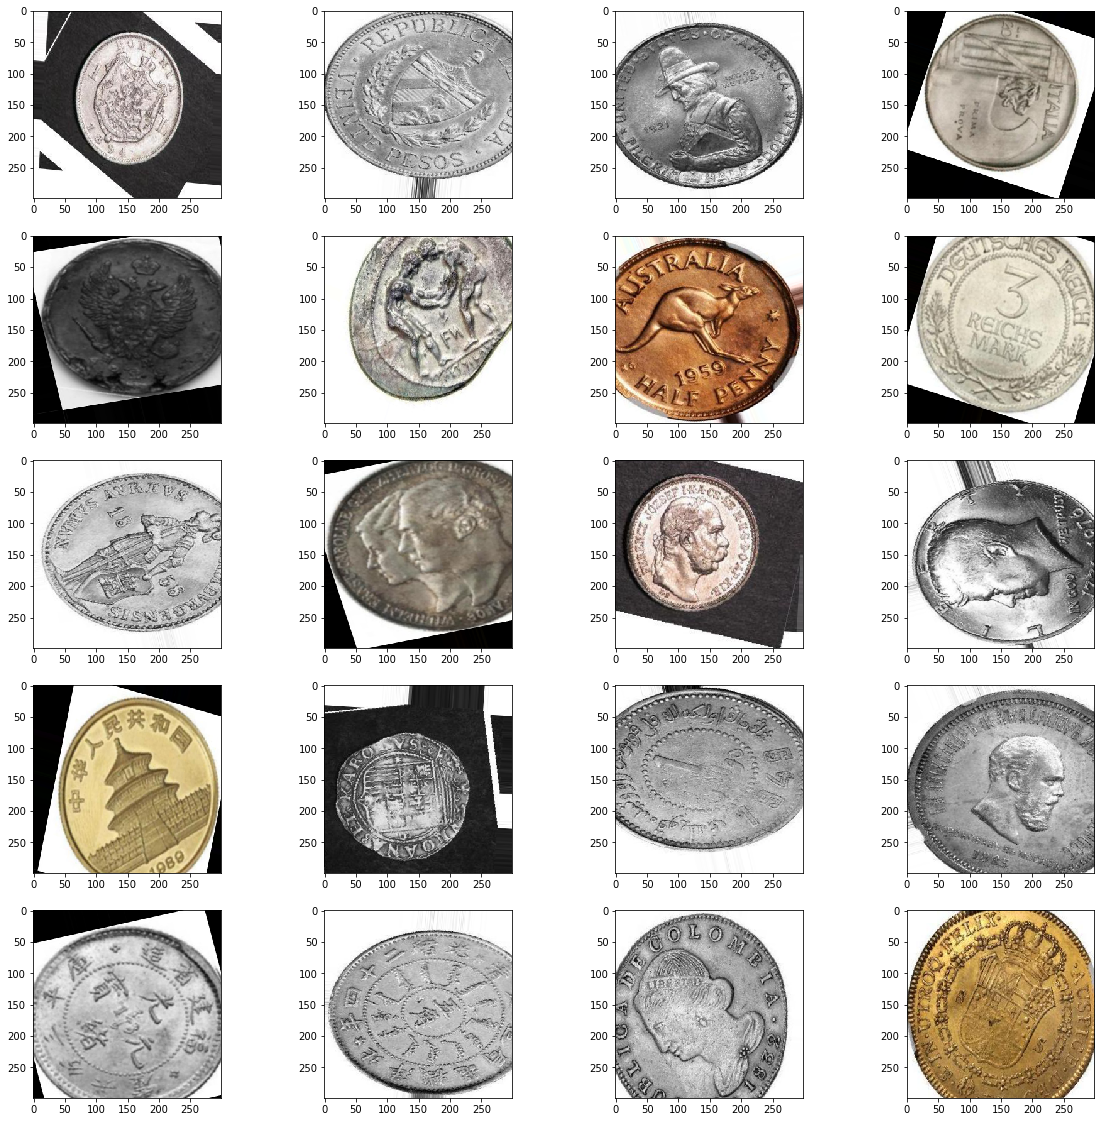

In [9]:
#show some images from train set
# rescale for better view: [-1:1] => [0:255]
img_to_plot_uint8 = (127.5*(x + 1)).astype(np.uint8)
fig=plt.figure(figsize=(20, 20))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_to_plot_uint8[i])
plt.show()

show histogram for a train image


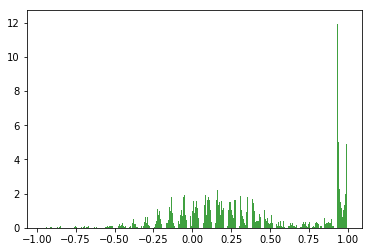

In [10]:
# show histogram for one sample used for training
print('show histogram for a train image')
n, bins, patches = plt.hist(x[0,:,:,1].reshape(ROWS, COLS), 25, density=1, facecolor='green', alpha=0.75)
plt.show()

In [11]:

input_shape = (ROWS, COLS, 3)
nclass = len(labels)

base_model = applications.InceptionV3(weights='imagenet', 
                                include_top=False, 
                                input_shape=(ROWS, COLS,3))
base_model.trainable = True

add_model = Sequential()
add_model.add(base_model)
add_model.add(GlobalAveragePooling2D())
#add_model.add(Dropout(0.3))
add_model.add(Dense(nclass, 
                    activation='softmax'))

model = add_model

model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy', 'top_k_categorical_accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4000)              8196000   
Total params: 29,998,784
Trainable params: 29,964,352
Non-trainable params: 34,432
_________________________________________________________________


In [12]:
# LOAD MODEL
#model.load_weights(file_path)

tr_steps_per_epoch = len(list_train) / train_batch_size

print('trainig steps per epoc: ', tr_steps_per_epoch)


checkpoint = ModelCheckpoint(MODEL_FILE_PATH, monitor='acc', verbose=1, save_best_only=False, mode='max')

early = EarlyStopping(monitor="acc", mode="max", patience=5)

callbacks_list = [checkpoint, early, tensorboard] #early

# validation_data works when train and validation sets have same amount of output classes

history = model.fit_generator(train_gen, 
                              epochs=train_epochs, 
                              steps_per_epoch=tr_steps_per_epoch,
                              shuffle=True, 
                              verbose=True,
#                              validation_data=test_gen,
#                              validation_steps=validation_steps, # fix me later if works
                              callbacks=callbacks_list)

trainig steps per epoc:  79556.328125
Epoch 1/3
79557/79556 [==============================] - 109165s 1s/step - loss: 0.9718 - acc: 0.8000 - top_k_categorical_accuracy: 0.8911

Epoch 00001: saving model to /home/spa/coin-vision/ssd-data/medium-4000-20190205/inception_v3_20190212-085833.hdf5
Epoch 2/3
79557/79556 [==============================] - 109038s 1s/step - loss: 0.0489 - acc: 0.9842 - top_k_categorical_accuracy: 0.9994

Epoch 00002: saving model to /home/spa/coin-vision/ssd-data/medium-4000-20190205/inception_v3_20190212-085833.hdf5
Epoch 3/3
79557/79556 [==============================] - 109275s 1s/step - loss: 0.0236 - acc: 0.9926 - top_k_categorical_accuracy: 0.9996

Epoch 00003: saving model to /home/spa/coin-vision/ssd-data/medium-4000-20190205/inception_v3_20190212-085833.hdf5


In [13]:
# RELOAD MODEL from the file (to make sure we use the same model for test/predictions)
model.load_weights(MODEL_FILE_PATH)


In [14]:
# test_gen_final uses same test data as test_idg. The difference is class_mode='binary' (test_idg uses class_mode='categorical' )

test_gen_final = test_idg.flow_from_directory(
    DATA_DIR + 'labeled-images-tst/',
    target_size=(ROWS, COLS),
    batch_size = final_test_batch_size,
    shuffle = False,
    class_mode='binary'
)


Found 118840 images belonging to 740 classes.


show some images from final test set


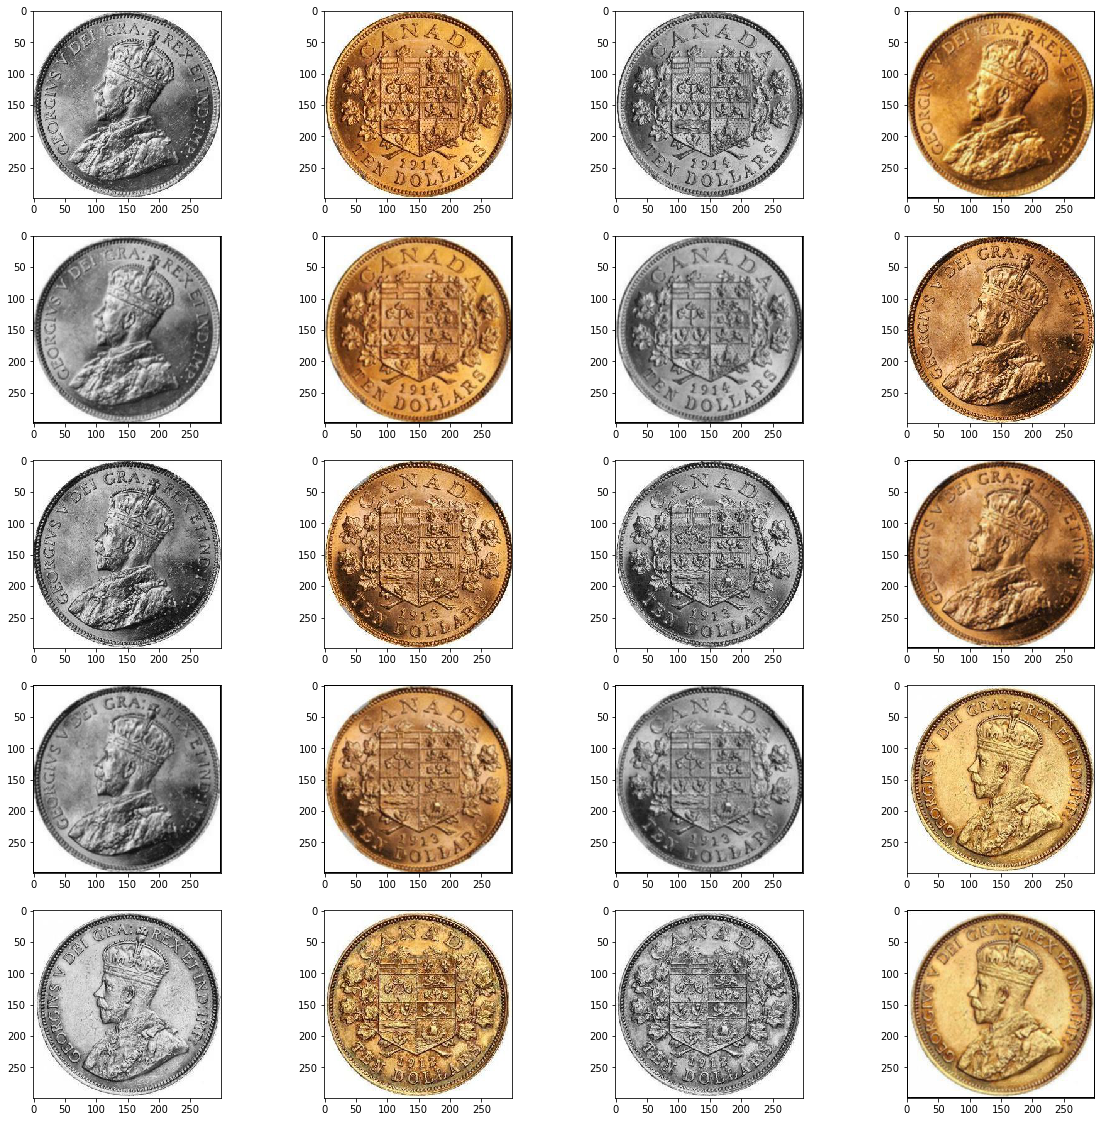

show histogram for a final test image. expected distirbution is [-1:1]


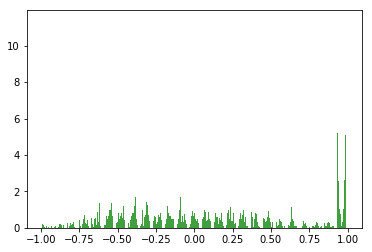

In [15]:
#show some images and histogram from final test set

print('show some images from final test set')
# rescale for better view: [-1:1] => [0:255]
x,y = test_gen_final.next()
img_to_plot_uint8 = (127.5*(x + 1)).astype(np.uint8)
fig=plt.figure(figsize=(20, 20))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_to_plot_uint8[i])
plt.show()

# show histogram for one sample used for training
print('show histogram for a final test image. expected distirbution is [-1:1]')
n, bins, patches = plt.hist(x[0,:,:,1].reshape(ROWS, COLS), 25, density=1, facecolor='green', alpha=0.75)
plt.show()

test_gen_final.reset() # to use displayed images in the final test

In [16]:
steps = int(len(list_test) / final_test_batch_size)
predicts_label_acc = []
y_true_label_acc = []

for step in range(steps):
    x_test,y_true = test_gen_final.next()
    predicts = model.predict_classes(x_test)
    label_index = {v: k for k,v in labels}
    predicts_label = [label_index[p] for p in predicts]
    y_true_label = [label_index[p] for p in y_true]
    predicts_label_acc.extend(predicts_label)
    y_true_label_acc.extend(y_true_label)
    print("done ", step, " from ", steps)



done  0  from  1188
done  1  from  1188
done  2  from  1188
done  3  from  1188
done  4  from  1188
done  5  from  1188
done  6  from  1188
done  7  from  1188
done  8  from  1188
done  9  from  1188
done  10  from  1188
done  11  from  1188
done  12  from  1188
done  13  from  1188
done  14  from  1188
done  15  from  1188
done  16  from  1188
done  17  from  1188
done  18  from  1188
done  19  from  1188
done  20  from  1188
done  21  from  1188
done  22  from  1188
done  23  from  1188
done  24  from  1188
done  25  from  1188
done  26  from  1188
done  27  from  1188
done  28  from  1188
done  29  from  1188
done  30  from  1188
done  31  from  1188
done  32  from  1188
done  33  from  1188
done  34  from  1188
done  35  from  1188
done  36  from  1188
done  37  from  1188
done  38  from  1188
done  39  from  1188
done  40  from  1188
done  41  from  1188
done  42  from  1188
done  43  from  1188
done  44  from  1188
done  45  from  1188
done  46  from  1188
done  47  from  1188
do

done  378  from  1188
done  379  from  1188
done  380  from  1188
done  381  from  1188
done  382  from  1188
done  383  from  1188
done  384  from  1188
done  385  from  1188
done  386  from  1188
done  387  from  1188
done  388  from  1188
done  389  from  1188
done  390  from  1188
done  391  from  1188
done  392  from  1188
done  393  from  1188
done  394  from  1188
done  395  from  1188
done  396  from  1188
done  397  from  1188
done  398  from  1188
done  399  from  1188
done  400  from  1188
done  401  from  1188
done  402  from  1188
done  403  from  1188
done  404  from  1188
done  405  from  1188
done  406  from  1188
done  407  from  1188
done  408  from  1188
done  409  from  1188
done  410  from  1188
done  411  from  1188
done  412  from  1188
done  413  from  1188
done  414  from  1188
done  415  from  1188
done  416  from  1188
done  417  from  1188
done  418  from  1188
done  419  from  1188
done  420  from  1188
done  421  from  1188
done  422  from  1188
done  423 

done  751  from  1188
done  752  from  1188
done  753  from  1188
done  754  from  1188
done  755  from  1188
done  756  from  1188
done  757  from  1188
done  758  from  1188
done  759  from  1188
done  760  from  1188
done  761  from  1188
done  762  from  1188
done  763  from  1188
done  764  from  1188
done  765  from  1188
done  766  from  1188
done  767  from  1188
done  768  from  1188
done  769  from  1188
done  770  from  1188
done  771  from  1188
done  772  from  1188
done  773  from  1188
done  774  from  1188
done  775  from  1188
done  776  from  1188
done  777  from  1188
done  778  from  1188
done  779  from  1188
done  780  from  1188
done  781  from  1188
done  782  from  1188
done  783  from  1188
done  784  from  1188
done  785  from  1188
done  786  from  1188
done  787  from  1188
done  788  from  1188
done  789  from  1188
done  790  from  1188
done  791  from  1188
done  792  from  1188
done  793  from  1188
done  794  from  1188
done  795  from  1188
done  796 

done  1119  from  1188
done  1120  from  1188
done  1121  from  1188
done  1122  from  1188
done  1123  from  1188
done  1124  from  1188
done  1125  from  1188
done  1126  from  1188
done  1127  from  1188
done  1128  from  1188
done  1129  from  1188
done  1130  from  1188
done  1131  from  1188
done  1132  from  1188
done  1133  from  1188
done  1134  from  1188
done  1135  from  1188
done  1136  from  1188
done  1137  from  1188
done  1138  from  1188
done  1139  from  1188
done  1140  from  1188
done  1141  from  1188
done  1142  from  1188
done  1143  from  1188
done  1144  from  1188
done  1145  from  1188
done  1146  from  1188
done  1147  from  1188
done  1148  from  1188
done  1149  from  1188
done  1150  from  1188
done  1151  from  1188
done  1152  from  1188
done  1153  from  1188
done  1154  from  1188
done  1155  from  1188
done  1156  from  1188
done  1157  from  1188
done  1158  from  1188
done  1159  from  1188
done  1160  from  1188
done  1161  from  1188
done  1162 

In [17]:
print(classification_report(predicts_label_acc,y_true_label_acc))


/home/spa/tensorflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/spa/tensorflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


                          precision    recall  f1-score   support

..PBwcI0wBsAAAEnqmjf8pU_       0.00      0.00      0.00         2
..UKbzbiG4sAAAFMAqAfTove       0.00      0.00      0.00         0
.0_BwcI0XI4AAAEnDzcQY_H.       0.00      0.00      0.00        49
.1rBwcI0e7cAAAEmHJ8dQQMJ       0.00      0.00      0.00         0
.2AKbzbixMoAAAFNJcVWb1AZ       0.00      0.00      0.00        90
.2IK.GJAAwEAAAEv.vbi7NnS       0.00      0.00      0.00       161
.3Z_AAEBL3AAAAEjErBucexH       0.00      0.00      0.00         0
.5UKX9ISdMEAAAFXjy0oxioj       0.00      0.00      0.00        92
.6jBwcI0UkEAAAErgUVbGgFO       0.00      0.00      0.00       136
.6nBwcI0B4QAAAErj0FbGgdy       0.00      0.00      0.00         0
.82vlrMpH_oAAAFl9QL7JAKF       0.00      0.00      0.00        63
.8_BwcI0Ab8AAAEocWd8PEZg       0.00      0.00      0.00        58
.94KbzbiZ_EAAAFMbxcfTodZ       0.00      0.00      0.00        28
.9nBwcI0fCsAAAEmTJw6TOhD       0.00      0.00      0.00         8
.AoKX9ISL

In [18]:
runTime = time.time() - startTime # script run time in sec

In [19]:
print('Total run time: {} min'.format(int(runTime/60)))

Total run time: 5491 min
